In [20]:
%matplotlib inline
import numpy as np
from numpy.linalg import norm as norm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import math as m
from scipy.special import hankel1 as hankel
from scipy.interpolate import interp1d
import scipy.constants as c

import matplotlib.pyplot as plt

# folder = 'C:/Users/jabuk/Documents/jaderka/diplomka/images_jup/'
folder = ''

yellow='#ffb200'
red='#DD5544'
blue='#0284C0'

In [2]:
class Permeability():
    def __init__(self):
        f= open('gold_pcgrate.txt', 'r')
        contents=f.readlines()

        self.wavelength=[]
        self.epsilon=[]
        self.real=[]
        self.imag=[]

        for line in contents[:-1]:
            line_split=line.split('\t')
            if 0.3<float(line_split[0])<1.5:
                self.wavelength.append(float(line_split[0])/1e6)
                
                eps=(float(line_split[1])+1j*float(line_split[2]))**2
                self.epsilon.append(eps)
                self.real.append(np.real(eps))
                self.imag.append(np.imag(eps))
        
        k=3
        self.sreal=interp1d(self.wavelength, self.real, kind='linear')
        self.simag=interp1d(self.wavelength, self.imag, kind='linear')

    def eps(self, lm):
        return self.sreal(lm)+1j*self.simag(lm)
    
metal=Permeability()

$\beta = [\frac{R_p}{2z_p}]^3$ 

$a = \sqrt{\frac{\epsilon_r}{-\epsilon_m}}$

$\alpha_e = \frac{6ak_0^3\epsilon_r^{3/2}V_p(\epsilon_p - \epsilon_r)}{\epsilon_p + 2\epsilon_r - 2(\epsilon_p - \epsilon_r)\beta}$

polarizability of a spherical nanoparticle in homogenious environment is:  
$\alpha = 3\epsilon_0V\frac{\epsilon(\omega) - \epsilon_m}{\epsilon(\omega) + 2\epsilon_m}$

relation of the cross-section to the effective plarizability [Bozhevolnyi]  
$\sigma = \frac{\alpha^2}{4Re\{\beta\}}$

In [3]:
def alpha(epsm, eps, d):
    #http://downloads.hindawi.com/journals/jnm/2007/045090.pdf
    V = 1/6*m.pi*d**3
    alpha = 3 * c.epsilon_0 * V * (eps - epsm)/(eps + 2 * epsm)
#     alpha = 4*m.pi*c.epsilon_0*(d/2)**3*(eps-1)/(eps+2)
    return alpha
    
def alpha_eff(ed, em, ep, r, z, lm):
#     metal=Permeability()
    em = em
    er = ed
        
    k0 = 2*m.pi/lm
    beta = (r/2/z)**3
        
    V = 4*m.pi*r**3/3
    a = (er/(-em))**0.5
    
    out = (6*a*k0**3*er**(3/2)*V*(ep-er))/(ep + 2*er - 2*(ep-er) * beta)
    return out

    
def U(k, x):
    return U0*np.exp(1j*np.dot(np.real(k), x))

def Udiff(k, r, x):
    rr=norm(x-r)
    p=np.dot(x-r, np.array([1,0]))/rr #scalar product disabling SPP with k perpendicular to original SPP
    if rr==0:
        return 0.2
    return 0.2*U(k, r)*np.exp(1j*rr*norm(np.real(k)))*p*np.exp(-norm(np.imag(k))*rr)#/((rr+2.93e6)**0.5)

def Pattern(ed, em, ep, r, z, lm, r0, x):
    alpha = alpha_eff(ed = 1,
                      em = metal.eps(lm),
                      ep = metal.eps(lm),
                      r = r, 
                      z = z, 
                      lm = lm).real
     
    
    k0 = 2*m.pi/lm
    epp=ed*em/(ed+em)
    
    beta=(k0*(epp**0.5)).real
    
    rr=norm(x-r0)
    p=np.dot(x-r0, np.array([1,0]))/rr #scalar product disabling SPP with k perpendicular to original SPP
    back = intensity(U(-k,x)+alpha * U(-k,r0)*1j/4*hankel(0, beta*np.linalg.norm(x - r0)))
    forward = intensity(U(k,x)+alpha* U(k,r0)*1j/4*hankel(0, beta*np.linalg.norm(x - r0)))
    return back+forward


def intensity(u):
    return u*np.conjugate(u)

In [4]:
lm = 650e-9
print(alpha_eff(ed = 1,
                em = metal.eps(lm),
                ep = metal.eps(lm),
                r = 100e-9, 
                z = 100e-9, 
                lm = lm).real
     )

15.037026980907743


In [5]:
15.037026980907743/1.2162504562244096

12.363429673512304

In [6]:
print(alpha(1, metal.eps(750e-9).real, 80e-9))
print(alpha(1, metal.eps(750e-9).real, 100e-9))
print(alpha(1, 1.58, 100e-9))

8.243767973290874e-33
1.6101109322833734e-32
2.2532717615610986e-33


In [7]:
1.6101109322833734e-32/2.2532717615610986e-33

7.145657970558624

In [8]:
alpha(1, 1.58, 80e-9)

1.1536751419192827e-33

In [9]:
U0=1

k=np.array([(11755041.21345882+78217.09878973379j), 0]) #750
# k=np.array([(15604823.125390332-526208.287757275j), 0]) #600
# k=np.array([(14000259.1178857-236982.93413896085j), 0]) #650

beta=k[0]
print(2*m.pi/beta)

(5.344861850844878e-07-3.5564280874350315e-09j)


In [25]:
# px = 1*1e-7
px = 2.93*1e-6
# X=np.arange(0,200*px, px)
# Y=np.arange(0,200*px, px)
# r=np.array([100,100])*px

X=np.arange(0,500*px, px)
Y=np.arange(0,500*px, px)
r=np.array([250,250])*px
alpha = 3


data=np.zeros([len(Y),len(X)])

for i in range(len(Y)):
    for j in range(len(X)):
        x=X[j]
        y=Y[i]
#         data[i,j]=intensity(U(k,np.array([x,y])))
#         data[i,j] = intensity(U(k,np.array([x,y]))+alpha* U(k,r)*1j/4*hankel(0, beta*np.linalg.norm(np.array([x, y]) - r)))
        data[i,j] = Pattern(ed = 1,
                            em = metal.eps(lm),
                            ep = 1.58,
                            r = 100e-9, 
                            z = 100e-9, 
                            lm = 750e-9,
                            r0 = r, 
                            x = np.array([x,y])
                           )
    
#         data[i,j] += U(k,r)*1j/4*hankel(0, beta*np.linalg.norm(np.array([x, y]) - r))
        
#         data[i,j] = intensity(data[i,j])
        





C:\Users\Bukacek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Bukacek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


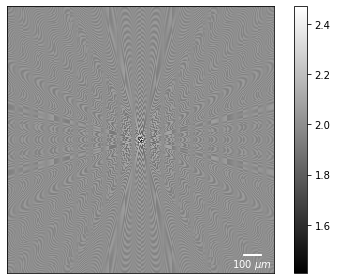

In [26]:
fig, ax = plt.subplots()
img = ax.imshow(data)
plt.set_cmap('gray')

fig.colorbar(img)
# ax.set_title('Interference pattern', fontsize=16)



fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
           34*2.93/px/1e6, '100 $\mu m$', 'lower right', 
           pad=0.1,
           color='white',
           frameon=False,
           size_vertical=1,
           fontproperties=fontprops)

ax.add_artist(scalebar)

for tick in ax.get_yticklines():
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for tick in ax.get_xticklabels():
    tick.set_visible(False)
    
plt.tight_layout()      
fig.savefig(folder + 'hankel_interference_ps.png', dpi = 300)
# ,clim=(0, 20)

In [ ]:
px = 5*1e-8
X=np.arange(0,200*px, px)
Y=np.arange(0,200*px, px)

r=np.array([100,100])*px
alpha = 3


data=np.zeros([len(Y),len(X)])

for i in range(len(Y)):
    for j in range(len(X)):
        x=X[j]
        y=Y[i]
#         data[i,j]=intensity(U(k,np.array([x,y])))
#         data[i,j] = intensity(U(k,np.array([x,y]))+alpha* U(k,r)*1j/4*hankel(0, beta*np.linalg.norm(np.array([x, y]) - r)))
        data[i,j] = hankel(0, beta*np.linalg.norm(np.array([x, y]) - r))
        
#         data[i,j] = intensity(data[i,j])
        





In [ ]:
fig, ax = plt.subplots()
img = ax.imshow(data)
plt.set_cmap('gray')

fig.colorbar(img)
# ax.set_title('$\mathcal{R}\{H_0^{1}\}$', fontsize=16)



fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
           34*2.93/px/1e8, '1 $\mu m$', 'lower right', 
           pad=0.1,
           color='white',
           frameon=False,
           size_vertical=1,
           fontproperties=fontprops)

ax.add_artist(scalebar)

for tick in ax.get_yticklines():
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for tick in ax.get_xticklabels():
    tick.set_visible(False)
    
plt.tight_layout()      
# fig.savefig(folder + 'hankel_real.png', dpi = 300)
# ,clim=(0, 20)

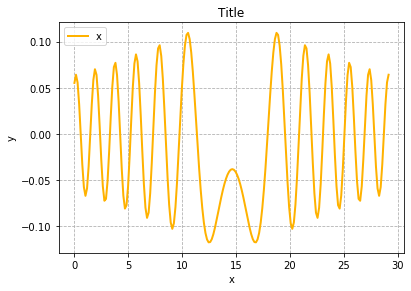

In [129]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='--')
axes.set_title('Title')
axes.set_xlabel('x')
axes.set_ylabel('y')

x = np.arange(1,10,0.2)
y = x**2 

name='test_01'
axes.plot(X*2.93e6,data[50,:], color=yellow, linewidth=2, label='x')
# axes.plot(x, x**3, color=blue, linewidth=2, label='y')
axes.legend(loc=2)
# fig.savefig('jupyter_plots/' + name + '.png', dpi=300)